In [3]:
import numpy as np
import matplotlib.pyplot as plt
%pylab inline
delta=5
def gausin_distance(x,y,delta=delta):
    H= torch.norm(x-y).cuda()
    distance = torch.exp(-H/2/(delta**2)).cuda()
    
    return distance
def gram_matrix(data,kernel=gausin_distance):
    #num=data.shape[0]
    #matrix=torch.zeros((num,num)).cuda()
    #for i in range (0,num):
    #   for j in range (0,num):
    #        matrix[i][j]=kernel(data[i],data[j])
    num=data.shape[0]
    datav3=torch.mm(data,torch.transpose(data, 0, 1).cuda()).cuda()
    datav1=torch.diag(datav3,0).cuda()
    #print(datav1.shape)
    #matrix=torch.sqrt(datav1+datav2-2*datav3)
    buf1=((-2)*datav3+datav1).cuda()
    buf2=torch.transpose(buf1, 0, 1).cuda()
    buf3=(buf2+datav1).cuda()
    #print(buf3)
    matrix = torch.exp(-buf3/2/(delta**2)).cuda()
    return matrix
def emerinal_hsic(X,Y):
    num=X.shape[0]
    #print(num)
    
    
    
    Kx=gram_matrix(X)
    
    Ky=gram_matrix(Y)
    
    H = torch.eye(num).cuda() - torch.ones((num,num), dtype = torch.float32).cuda() / num
    #print(H)
    hsic=1/(num-1)*torch.trace(torch.mm(torch.mm(torch.mm(Kx,H).cuda(),Ky).cuda(),H).cuda()).cuda()
    
    return hsic
import torch
import torchvision
from torchvision import transforms
import torch.nn.functional as F
import torchvision.datasets
from PIL import Image
batch_size=256
class MyMNIST(torchvision.datasets.MNIST):
    def __init__(self, root, train=True, transform=None, target_transform=None,download=False):
        
        super(MyMNIST,self).__init__(root, train, transform, target_transform,download)
        #print(self.data)
    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], int(self.targets[index])
        #print(target) 
        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img.numpy(), mode='L')

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)
            
        else:
            target=torch.as_tensor(target)
            target = F.one_hot(target,num_classes=10).cuda()

        return img, target
mnist_data=torchvision.datasets.MNIST(root='./MNIST/', train=True, transform=transforms.ToTensor(), target_transform=None, download=False)
data_loader = torch.utils.data.DataLoader(mnist_data,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=2)
#D_in, H1,H2,H3,H4,H5,H6,H7, D_out = 784, 64,32,16,8,4,2,1,10
layer_num=[784,64]
costs=[]
dtype=torch.float
continue_flag=1
PATH='./checkpoint_nbp_mlp_theroytest'
w=[]
z=[]
rate_list=[]
reset_list=[0]
if continue_flag:
    
    checkpoint = torch.load(PATH)
    
    w=checkpoint['w']
    
    for k in reset_list:
        w[k].reset_parameters()
        

else:
    for i in range(len(layer_num)-1):
    
        
        m = torch.nn.Linear(784,128).cuda()
        w.append(m)
        
        m=torch.nn.Linear(128,64).cuda()
        w.append(m)
        #print(m.weight.shape)
        m=torch.nn.Linear(64,32).cuda()
        w.append(m)
        m=torch.nn.Linear(32,16).cuda()
        w.append(m)
        m=torch.nn.Linear(16,8).cuda()
        w.append(m)
        m=torch.nn.Linear(8,1).cuda()
        w.append(m)


epoches=40
lamda=20
entropy_rate=0.01
learning_rate=0.001
learning_ratel=0.000
data_tsne_label=[]
data_tsne_rp1=[]
data_tsne_rp2=[]
for i in range(epoches): 
    for i_batch, (img,target) in enumerate(data_loader):
        z=[]
        costs=[]
        informs=[]
        entropys=[]
        img=img.reshape(-1,784).cuda()
        
        target=torch.as_tensor(target).cuda()
        num=target.shape[0]
        #print(num)
        target=target.reshape(num,1).cuda()
        #target = F.one_hot(target,num_classes=10).cuda()
        target=torch.zeros((num,10)).cuda().scatter_(1,target,1).cuda()
        
        target=torch.as_tensor(target,dtype=dtype).cuda()
        
        z.append(F.relu((w[0](img))).cuda())
        #print(z[0].shape)
        #for cnt in range(len(w)-1):
            
        #   z.append(torch.tanh(torch.mm(z[cnt],w[cnt+1]).cuda()).cuda())
        z.append(F.relu((w[1](z[0]))).cuda())
       # print(z[1].shape)
        z.append(F.relu((w[2](z[1]))).cuda())
       # print(z[2].shape)
        z.append(F.relu((w[3](z[2]))).cuda())
       # print(z[3].shape)
        z.append(F.relu((w[4](z[3]))).cuda())
       # print(z[4].shape)
        z.append(F.relu((w[5](z[4]))).cuda())
        #print(z[5].shape)
        
        
        grad_listw=[]
        grad_listb=[]
        lay=1
        h=z[lay].view(img.shape[0],-1).cuda()
        #print(h[:,1].shape)
        information=lamda*emerinal_hsic(h.view(img.shape[0],-1),target)
        entropy=emerinal_hsic(h.view(img.shape[0],-1),img.view(-1,784).cuda())
        
        cost=0
        for i in range(h.shape[1]):
            cost=cost-lamda*emerinal_hsic(h[:,i].view(img.shape[0],1),target)
        cost=cost-20*information
        entropys.append(entropy)
        informs.append(information)
        costs.append(cost)
        cost.backward(retain_graph=True)
        lock_bplist=[1]
        with torch.no_grad():
            for cnt in lock_bplist:
                bufw=torch.zeros((w[cnt].weight.shape)).cuda()
                #print(buf.shape)
                bufw.copy_(w[cnt].weight.grad)
                
                grad_listw.append(bufw)
                
                bufb=torch.zeros((w[cnt].bias.shape)).cuda()
                #print(buf.shape)
                bufb.copy_(w[cnt].bias.grad)
                
                grad_listb.append(bufb)
            for nu in range(lay+1):
                w[nu].weight.grad.zero_()
                w[nu].bias.grad.zero_()
        
        '''
        for cnt in range(lock_list):
            information=lamda*emerinal_hsic(z[cnt].view(img.shape[0],-1).cuda(),target)
            entropy=emerinal_hsic(z[cnt].view(img.shape[0],-1).cuda(),img.view(-1,784).cuda())
            cost=-entropy-information
            entropys.append(entropy)
            informs.append(information)
            costs.append(cost)
        #print(cost1)
            cost.backward(retain_graph=True)
        #    print('!')
        #print(w1.cuda().grad)
            with torch.no_grad():
                bufw=torch.zeros((w[cnt].weight.shape)).cuda()
                #print(buf.shape)
                bufw.copy_(w[cnt].weight.grad)
                
                grad_listw.append(bufw)
                
                bufb=torch.zeros((w[cnt].bias.shape)).cuda()
                #print(buf.shape)
                bufb.copy_(w[cnt].bias.grad)
                
                grad_listb.append(bufb)
            #print('grad1',torch.norm(grad1))
            #w2 -= learning_rate * w2.grad

            # Manually zero the gradients after updating weights
                for nu in range(cnt+1):
                    w[nu].weight.grad.zero_()
                    w[nu].bias.grad.zero_()
                #print(cnt,torch.norm(buf))
            #w2.grad.zero_()
        '''
        z[-1]=z[-1].view(img.shape[0],-1).cuda()
        #print(z[-1].shape)
        img=img.view(img.shape[0],-1).cuda()
        entropy=emerinal_hsic(z[-1],img.view(-1,784).cuda())
        information=lamda*emerinal_hsic(z[-1],target)
        rate=entropy/information
        cost=-information-entropy
        #+0.1*(entropy/information)
        costs.append(cost)
        informs.append(information)
        entropys.append(entropy)
        
        
        cost.backward()
        lock_list=[]
        with torch.no_grad():
            #w1 -= learning_rate * w1.grad
            #print('grad2',torch.norm(w2.grad))
            w[-1].weight -= learning_ratel * w[-1].weight.grad
            w[-1].bias-= learning_ratel * w[-1].bias.grad
            w[-1].weight.grad.zero_()
            w[-1].bias.grad.zero_()
            for cnt in lock_list:
                w[cnt].weight -= learning_rate * w[cnt].weight.grad
                w[cnt].bias -= learning_rate * w[cnt].bias.grad
            for cnt in range(len(z)-1):
                w[cnt].weight.grad.zero_()
                w[cnt].bias.grad.zero_()
            for cnt in lock_bplist:
                w[cnt].weight -= learning_rate * grad_listw[0]
                w[cnt].bias -= learning_rate * grad_listb[0]
            #w[0].weight -= learning_rate * w[0].weight.grad
            #w[1].weight -= learning_rate * w[1].weight.grad
            #w[2].weight -= learning_rate * w[2].weight.grad
            
        # Manually zero the gradients after updating weights
            
        #    data_tsne_rp2.append(z2.cpu().data.numpy())
        #    data_tsne_rp1.append(z1.cpu().data.numpy())
        #    data_tsne_label.append(target.argmax(dim=1, keepdim=True).cpu().data.numpy())
        

        if i_batch %100 ==0:
            #costs.append(cost)
            #print(rate)
            rate_list.append(rate)
            print(i_batch)
            print('costs',costs)
            print('entropys',entropys)
            print('informs',informs)
            print('entr',entropy)
            print('inf',information)
            data_tsne_label.append(target.argmax(dim=1, keepdim=True).cpu().data.numpy())
            torch.save({
            'w': w,
            'z': z,
            'data_tsne_label':target.argmax(dim=1, keepdim=True).cpu().data.numpy()
            ,'costs':costs
            #'data_tsne_rp2':data_tsne_rp2,
            #'data_tsne_rp1':data_tsne_rp1
                
            }, PATH)
            
            data_tsne_label=[]
            #data_tsne_rp1=[]
            #data_tsne_rp2=[]

            #for j,zz in enumerate(z2):
                #print(j,zz)
                #print(j,target[j])
            
plt.plot(rate_list)
plt.ylabel('rate')
plt.xlabel('epochs (per 1)')
plt.title("Learning rate = " + str(learning_rate))
plt.show()

Populating the interactive namespace from numpy and matplotlib
0
costs [tensor(-0.2672, device='cuda:0', grad_fn=<SubBackward0>), tensor(-5.9206e-08, device='cuda:0', grad_fn=<SubBackward0>)]
entropys [tensor(0.0100, device='cuda:0', grad_fn=<MulBackward0>), tensor(2.7999e-08, device='cuda:0', grad_fn=<MulBackward0>)]
informs [tensor(0.0127, device='cuda:0', grad_fn=<MulBackward0>), tensor(3.1207e-08, device='cuda:0', grad_fn=<MulBackward0>)]
entr tensor(2.7999e-08, device='cuda:0', grad_fn=<MulBackward0>)
inf tensor(3.1207e-08, device='cuda:0', grad_fn=<MulBackward0>)
100
costs [tensor(-0.3046, device='cuda:0', grad_fn=<SubBackward0>), tensor(-1.1149e-07, device='cuda:0', grad_fn=<SubBackward0>)]
entropys [tensor(0.0109, device='cuda:0', grad_fn=<MulBackward0>), tensor(5.7450e-08, device='cuda:0', grad_fn=<MulBackward0>)]
informs [tensor(0.0145, device='cuda:0', grad_fn=<MulBackward0>), tensor(5.4038e-08, device='cuda:0', grad_fn=<MulBackward0>)]
entr tensor(5.7450e-08, device='cuda:0

KeyboardInterrupt: 

Populating the interactive namespace from numpy and matplotlib
{'0': [], '1': [], '2': [], '3': [], '4': [], '5': [], '6': [], '7': [], '8': [], '9': []}
!!!!
[1.3569461  0.36334908 0.91668594 3.0746226  0.         2.0263195
 0.00878672 1.1856297  0.         0.23388688 0.7335374  2.3845935
 0.15361273 3.275082   0.20469964 0.09729932 3.1592183  0.
 1.0088814  1.9483719  1.7112498  0.62654644 1.8661339  0.38407725
 0.         0.6016363  1.3842304  0.         0.         0.36568633
 2.7504766  0.         0.76507586 0.16651355 0.32643175 3.2639601
 1.6766855  0.         2.0855803  2.572958   1.4620289  0.9907608
 0.         0.03805352 3.3986077  0.41946116 0.         3.6540985
 5.3150105  0.03514835 2.1536782  0.18168853 0.23050499 0.
 0.21963139 0.37125608 3.2432456  0.         0.22518349 0.04726203
 1.1132578  0.17173572 1.2993269  4.351323  ]
[1.46156633e+00 4.88492787e-01 9.69250381e-01 4.48438406e+00
 0.00000000e+00 1.70392358e+00 0.00000000e+00 1.09021246e+00
 0.00000000e+00 4.874290

/usr/local/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['dtype', 'rate', 'entropy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


255


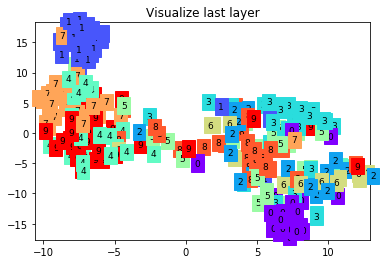

In [4]:
import torch
import matplotlib.pyplot as plt
from matplotlib import cm
%pylab inline
import numpy as np
try: from sklearn.manifold import TSNE; HAS_SK = True
except: HAS_SK = False; print('Please install sklearn for layer visualization')
def plot_with_labels(lowDWeights, labels):
    plt.cla()
    X, Y = lowDWeights[:, 0], lowDWeights[:, 1]
    print(len(labels))
    for x, y, s in zip(X, Y, labels):
        c = cm.rainbow(int(255 * s / 9)); plt.text(x, y, s, backgroundcolor=c, fontsize=9)
    plt.xlim(X.min(), X.max()); plt.ylim(Y.min(), Y.max()); plt.title('Visualize last layer'); plt.show(); plt.pause(0.01)

plt.ion()
PATH='./checkpoint_nbp_mlp_theroytest'
checkpoint = torch.load(PATH)
data_tsne_label=np.array(checkpoint['data_tsne_label'])
data_tsne_rp=np.array(checkpoint['z'][1].view(data_tsne_label.shape[0],-1).cpu().data.numpy())
#print(data_tsne_rp.shape)
#print(data_tsne_rp[:50,:],data_tsne_label[:50])
#for j in range(256):
#    sums=0
#    if data_tsne_label[j]==1:
#        for i in range((data_tsne_rp.shape[1])):
#            if data_tsne_rp[j][i]>=0:
#                x=1
#            else:
#                x=0
#            sums+=x*np.power(0.2,i)
#        print(sums)
#print()

pic={'0':[],'1':[],'2':[],'3':[],'4':[],'5':[],'6':[],'7':[],'8':[],'9':[]}
print(pic)
for i in range(10):
    print('!!!!')
    for j in range(256):
        if data_tsne_label[j]==i:
           # print(i,str(i))
           # pic[str(i)].append(data_tsne_rp[j])
           # print(data_tsne_label[j])
           print(data_tsne_rp[j])
data_tsne_label=data_tsne_label.reshape((-1))
plt.hist(data_tsne_rp[:1024], bins=200, range=(10,80),histtype="stepfilled", alpha=.8)

#print(np.histogram(data_tsne_rp[:200],bins=100,range=(0,100)))
#for i in range(10):
    #plt.hist(pic[str(i)], bins=100, range=(0,100),normed=True,histtype="stepfilled", alpha=.8)
    #print('!!!')
    #print(pic[str(i)])
#print(data_tsne_label)
#data_tsne=np.array(data_tsne[:][])
if HAS_SK:
    # Visualization of trained flatten layer (T-SNE)
    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
    plot_only = 255
    low_dim_embs = tsne.fit_transform(data_tsne_rp[:plot_only,:])
    labels = data_tsne_label[:plot_only]
    plot_with_labels(low_dim_embs, labels)
plt.ioff()